**Import librerie**

In [3]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image

print(torch.__version__)
print(torch.cuda.is_available())
#print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

2.4.1+cu121
True
cuda:0


In [3]:
#os.remove('/kaggle/working/U-Net.pth')

# Dataset

In [4]:
remapping = {
    
        0: 255,# void
        1: 255,
        2: 255,
        3: 255,
        4: 255,
        5: 255,
        6: 255,
        7: 0,
        8: 1,
        9: 255,
        10: 255,
        11: 2,
        12: 3,
        13: 4,
        14: 255,
        15: 255,
        16: 255,
        17: 5,
        18: 255,
        19: 6,
        20: 7,        
        21: 8,
        22: 9,
        23: 10,
        24: 11,
        25: 12,
        26: 13,
        27: 14,
        28: 15,
        29: 255,
        30: 255,
        31: 16,
        32: 17,
        33: 18
    
    }

class_dict = {
    0: 'road', 1: 'sidewalk', 2: 'building', 3: 'wall',
    4: 'fence', 5: 'pole', 6: 'traffic light', 7: 'traffic sign', 8: 'vegetation', 9: 'terrain',
    10: 'sky', 11: 'person', 12: 'rider', 13: 'car', 14: 'truck',
    15: 'bus', 16: 'train', 17: 'motorcycle', 18: 'bicycle', 255: 'void'

}

(1024, 2048, 3) (1024, 2048)


Text(0.5, 1.0, 'Ground Truth')

<Figure size 640x480 with 0 Axes>

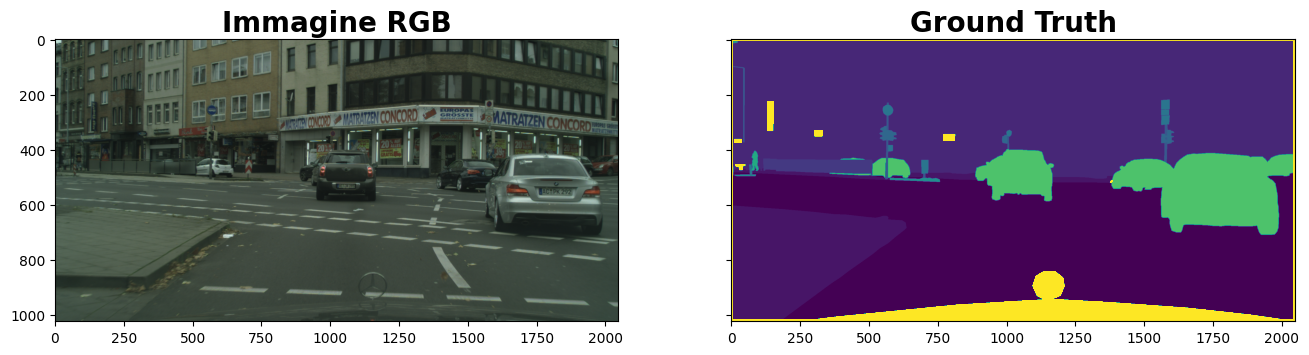

In [5]:
img = imageio.imread('/kaggle/input/cityscapes/Cityspaces/images/train/aachen/aachen_000003_000019_leftImg8bit.png')
gt = imageio.imread('/kaggle/input/cityscapes/Cityspaces/gtFine/train/aachen/aachen_000003_000019_gtFine_labelIds.png')

gt = np.vectorize(remapping.get)(gt)# Re-mapping delle classi con 19 classi

print(img.shape, gt.shape)

plt.figure()
fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize=(16,7))
axs[0].imshow(img)
axs[0].set_title('Immagine RGB', fontsize=20, fontweight='bold')
axs[1].imshow(gt, clim = [0,18])
axs[1].set_title('Ground Truth', fontsize=20, fontweight='bold')

In [6]:
basepath = '/kaggle/input/cityscapes/Cityspaces'
#root = '/kaggle/input/cityscapes/Cityspaces/'
img_train_dir = os.path.join(basepath,'/images/train')
gts_train_dir = os.path.join(basepath,'/gtFine/train')

img_val_dir = os.path.join(basepath,'/images/val')
gts_val_dir = os.path.join(basepath,'/gtFine/val')

train_zones_img = list(sorted(next(os.walk('/kaggle/input/cityscapes/Cityspaces/images/train'))[1])) #creiamo una lista con tutte le città di training
train_zones_gt = list(sorted(next(os.walk('/kaggle/input/cityscapes/Cityspaces/gtFine/train'))[1])) #creiamo una lista con tutte le città di training

val_zones_img = train_zones_img[-4:]
train_zones_img = train_zones_img[:-4]

val_zones_gt = train_zones_gt[-4:]
train_zones_gt = train_zones_gt[:-4]


img_path_train = [] #lista che conterrà tutti i path dei file di immagini
for name in train_zones_img:
        mat_root = os.path.join(basepath, 'images', 'train', name)
        img_names = sorted(next(os.walk(mat_root))[2])
        for i in range(len(img_names)):
            img_path_train.append(os.path.join(mat_root, img_names[i]))
            
gt_path_train = [] #lista che contiene tutti i path dei GT
for name in train_zones_gt:
        mat_root = os.path.join(basepath, 'gtFine', 'train', name) #prendiamo solo le label per la semantic segmentation
        img_names = sorted(next(os.walk(mat_root))[2])
        img_names = list(filter(lambda k: 'labelIds.png' in k, img_names))
        for i in range(len(img_names)):
            gt_path_train.append(os.path.join(mat_root, img_names[i]))


img_path_val = [] #lista che conterrà tutti i path dei file di immagini
for name in val_zones_img:
        mat_root = os.path.join(basepath, 'images', 'train', name)
        img_names = sorted(next(os.walk(mat_root))[2])
        for i in range(len(img_names)):
            img_path_val.append(os.path.join(mat_root, img_names[i]))
            
gt_path_val = [] #lista che contiene tutti i path dei GT
for name in val_zones_gt:
        mat_root = os.path.join(basepath, 'gtFine', 'train', name) #prendiamo solo le label per la semantic segmentation
        img_names = sorted(next(os.walk(mat_root))[2])
        img_names = list(filter(lambda k: 'labelIds.png' in k, img_names))
        for i in range(len(img_names)):
            gt_path_val.append(os.path.join(mat_root, img_names[i]))



test_zones_img = list(sorted(next(os.walk('/kaggle/input/cityscapes/Cityspaces/images/val'))[1])) #creiamo una lista con tutte le città di validation
test_zones_gt = list(sorted(next(os.walk('/kaggle/input/cityscapes/Cityspaces/gtFine/val'))[1])) #creiamo una lista con tutte le città di validation

img_path_test = [] #lista che conterrà tutti i path dei file di immagini
for name in test_zones_img:
        mat_root = os.path.join(basepath, 'images', 'val', name)
        img_names = sorted(next(os.walk(mat_root))[2])
        for i in range(len(img_names)):
            img_path_test.append(os.path.join(mat_root, img_names[i]))
            
gt_path_test = [] #lista che contiene tutti i path dei GT
for name in test_zones_gt:
        mat_root = os.path.join(basepath, 'gtFine', 'val', name) #prendiamo solo le label per la semantic segmentation
        img_names = sorted(next(os.walk(mat_root))[2])
        img_names = list(filter(lambda k: 'labelIds.png' in k, img_names))
        for i in range(len(img_names)):
            gt_path_test.append(os.path.join(mat_root, img_names[i]))



print(f"Dimensione train set: {len(img_path_train)}, {len(gt_path_train)}")
print(f"Dimensione val set: {len(img_path_val)}, {len(gt_path_val)}")
print(f"Dimensione test set: {len(img_path_test)}, {len(gt_path_test)}")

Dimensione train set: 2472, 2472
Dimensione val set: 503, 503
Dimensione test set: 500, 500


**Dataset class override**

In [8]:
from torchvision.transforms.functional import InterpolationMode

class CustomDataset(Dataset):
    def __init__(self, images_paths, gt_paths, mode='train'):
        """
        Args:
            images_paths: List of paths to the input images.
            gt_paths: List of paths to the ground truth labels.
            mode: Specifies the dataset mode: 'train', 'val', or 'test'.
        """
        self.image_paths = images_paths
        self.gt_paths = gt_paths
        self.mode = mode
        
    def __len__(self):
        return len(self.image_paths)

    
    def transform_train(self, image, gt):

        # Resize without random cropping
        
        image = T.functional.resize(image, (512, 1024), interpolation=InterpolationMode.BILINEAR)
        gt = T.functional.resize(gt, (512, 1024), interpolation=InterpolationMode.NEAREST_EXACT)
        
        '''
        # Random crop
        i, j, h, w = T.RandomCrop.get_params(image, output_size=(256, 512))
        image = T.functional.crop(image, i, j, h, w)
        gt = T.functional.crop(gt, i, j, h, w)
        
        # Random horizontal flip
        if random.random() > 0.5:
            image = T.functional.hflip(image)
            gt = T.functional.hflip(gt)

        '''
        '''
        # Random vertical flip
        if random.random() > 0.5:
            image = T.functional.vflip(image)
            gt = T.functional.vflip(gt)
        '''

        return image, gt

    def transform_val_test(self, image, gt):

        # Resize without random cropping
        image = T.functional.resize(image, (512, 1024), interpolation=InterpolationMode.BILINEAR)
        gt = T.functional.resize(gt, (512, 1024), interpolation=InterpolationMode.NEAREST_EXACT)

        return image, gt

    def __getitem__(self, index):
        
        # ATTENZIONE: torchvision.transforms.functional opera solo su immagini aperte con PIL
        image = Image.open(self.image_paths[index])
        gt = Image.open(self.gt_paths[index])
        # Apply transformations based on the mode
        if self.mode == 'train':
            image, gt = self.transform_train(image, gt)
        else:  # For 'val' or 'test'
            image, gt = self.transform_val_test(image, gt)

        # Convert to NumPy and torch.Tensor
        image = np.array(image).astype(np.float32) / 255.0
        gt = np.vectorize(remapping.get)(gt)# Re-mapping delle classi con 8 classi
        gt = np.array(gt)
        gt = torch.tensor(gt, dtype=torch.long)
        image = self.transform_img(image)
        
        return image, gt

    def transform_img(self, image):
     
        transform_ops = T.Compose([
                                            T.ToTensor(),
            
                                            T.Normalize(mean=(0.28881703, 0.32694227, 0.28622528), std=(0.18679116, 0.18973092, 0.18646142))
            
                                            #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ])
        return transform_ops(image)

# Example usage:
# train_dataset = CustomDataset(train_image_paths, train_gt_paths, mode='train')
# val_dataset = CustomDataset(val_image_paths, val_gt_paths, mode='val')
# test_dataset = CustomDataset(test_image_paths, test_gt_paths, mode='test')

**Train and Validation Dataset**

In [6]:
'''
# Prendere metà delle immagini
img_path_train = img_path_train[:len(img_path_train) // 4]
gt_path_train = gt_path_train[:len(gt_path_train) // 4]

img_path_val = img_path_val[:len(img_path_val) // 4]
gt_path_val = gt_path_val[:len(gt_path_val) // 4]

img_path_test = img_path_test[:len(img_path_test) // 4]
gt_path_test = gt_path_test[:len(gt_path_test) // 4]

print(f"Dimensione train set: {len(img_path_train)}, {len(gt_path_train)}")
print(f"Dimensione val set: {len(img_path_val)}, {len(gt_path_val)}")
print(f"Dimensione test set: {len(img_path_test)}, {len(gt_path_test)}")
'''


'\n# Prendere metà delle immagini\nimg_path_train = img_path_train[:len(img_path_train) // 4]\ngt_path_train = gt_path_train[:len(gt_path_train) // 4]\n\nimg_path_val = img_path_val[:len(img_path_val) // 4]\ngt_path_val = gt_path_val[:len(gt_path_val) // 4]\n\nimg_path_test = img_path_test[:len(img_path_test) // 4]\ngt_path_test = gt_path_test[:len(gt_path_test) // 4]\n\nprint(f"Dimensione train set: {len(img_path_train)}, {len(gt_path_train)}")\nprint(f"Dimensione val set: {len(img_path_val)}, {len(gt_path_val)}")\nprint(f"Dimensione test set: {len(img_path_test)}, {len(gt_path_test)}")\n'

In [9]:
# Get train and val dataset instances
train_dataset = CustomDataset(img_path_train, gt_path_train, mode='train')
valid_dataset = CustomDataset(img_path_val, gt_path_val, mode='val')
test_dataset = CustomDataset(img_path_test, gt_path_test, mode='test')

print(f"Dimensione train set: {len(img_path_train)}, {len(gt_path_train)}")
print(f"Dimensione val set: {len(img_path_val)}, {len(gt_path_val)}")
print(f"Dimensione test set: {len(img_path_test)}, {len(gt_path_test)}")
    
# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8)

Dimensione train set: 2472, 2472
Dimensione val set: 503, 503
Dimensione test set: 500, 500


**Check**

Single example: torch.Size([3, 512, 1024]), torch.Size([512, 1024])
Batch example: torch.Size([4, 3, 512, 1024]),torch.Size([4, 512, 1024])
Single example: torch.Size([3, 512, 1024]), torch.Size([512, 1024])


Text(0.5, 1.0, 'Ground Truth')

<Figure size 640x480 with 0 Axes>

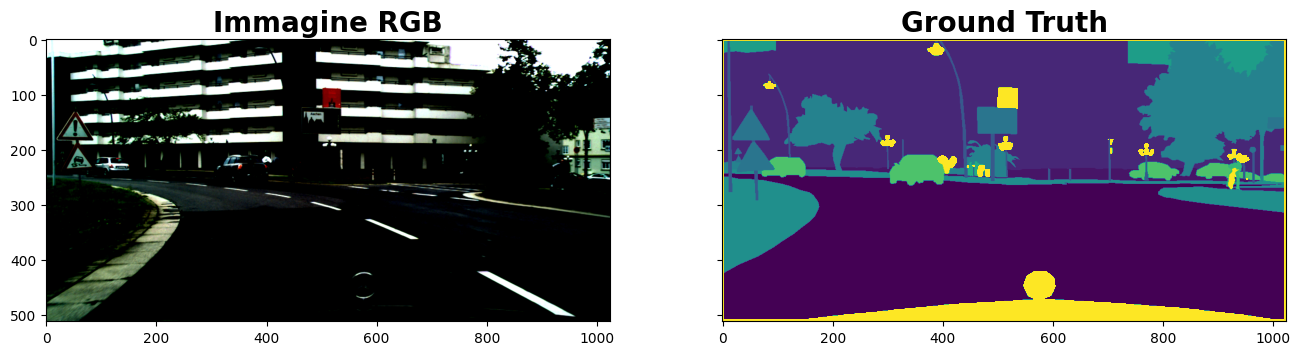

<Figure size 640x480 with 0 Axes>

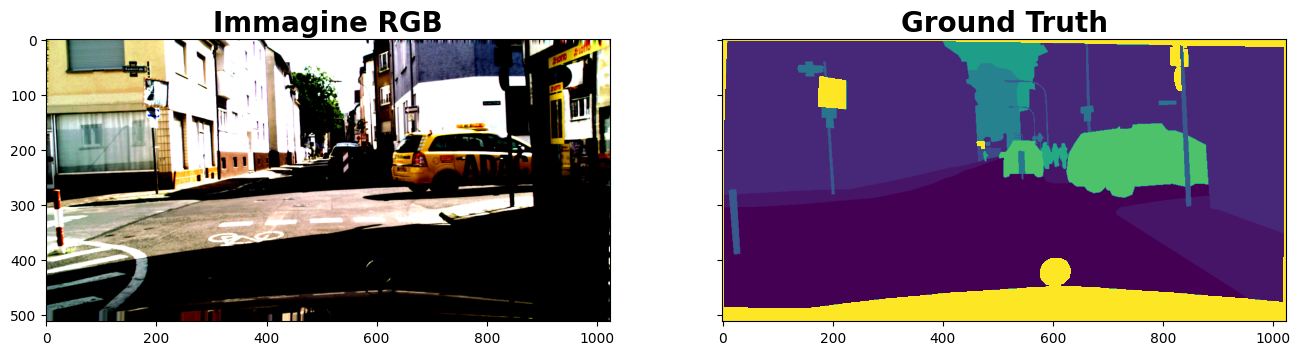

In [10]:
single_example, single_gt = train_dataset[0]

prova = np.transpose(single_example, (1, 2, 0))
#prova_gt = np.transpose(single_gt, (1, 2, 0))

print(f"Single example: {single_example.shape}, {single_gt.shape}")

for data in train_loader:
    batch_example, batch_gt = data
    break

print(f"Batch example: {batch_example.shape},{batch_gt.shape}")

plt.figure()
fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize=(16,7))
axs[0].imshow(prova)
axs[0].set_title('Immagine RGB', fontsize=20, fontweight='bold')
axs[1].imshow(single_gt, clim=[0,18])
axs[1].set_title('Ground Truth', fontsize=20, fontweight='bold')

single_example2, single_gt2 = test_dataset[0]

prova2 = np.transpose(single_example2, (1, 2, 0))
#prova_gt = np.transpose(single_gt, (1, 2, 0))

print(f"Single example: {single_example2.shape}, {single_gt2.shape}")

plt.figure()
fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize=(16,7))
axs[0].imshow(prova2)
axs[0].set_title('Immagine RGB', fontsize=20, fontweight='bold')
axs[1].imshow(single_gt2, clim=[0,18])
axs[1].set_title('Ground Truth', fontsize=20, fontweight='bold')

# Definizione Rete Neurale
<h3><center>ResNet Model Architecture</center></h3>

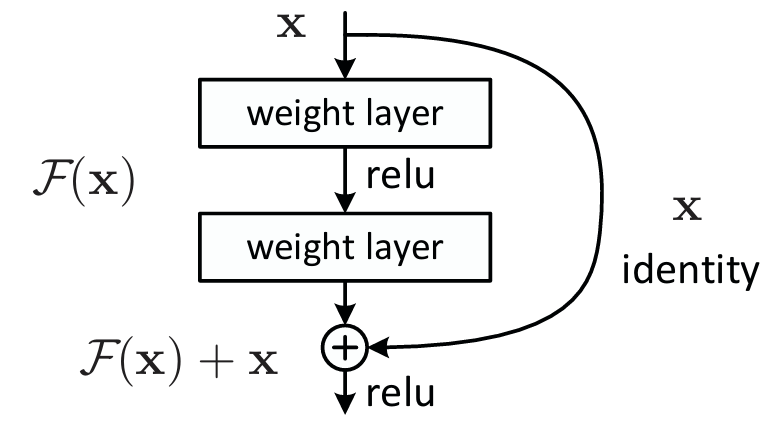
<h4><center><a href="https://arxiv.org/abs/1512.03385">Image Courtesy: Deep Residual Learning for Image Recognition [He et al.]</a></center></h4>


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

num_classes=19

# Definizione di un blocco ResNet (ResBlock)
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))   # Primo layer + ReLU
        out = self.bn2(self.conv2(out))         # Secondo layer
        out += self.shortcut(x)                 # Aggiunta della connessione residua
        out = F.relu(out)                       # ReLU finale
        return out

# Definizione della ResNet
class ResNetDecoder(nn.Module):
    def __init__(self, block, num_blocks, num_classes=num_classes):
        super(ResNetDecoder, self).__init__()
        
        # Strato iniziale
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Strati successivi (4 gruppi di blocchi)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Decoder layers 
        self.upconv1 = self._decoder_block(512, 256)  
        self.upconv2 = self._decoder_block(256, 128)
        self.upconv3 = self._decoder_block(128, 64)
        self.upconv4 = self._decoder_block(64, 64)
        self.upconv5 = self._decoder_block(64, 64)
        
        # Layer finale per la segmentazione
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def _decoder_block(self, in_channels, out_channels):
        # Decoder block per l'upsampling (transposed convolution)
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        x = self.maxpool(F.relu(self.bn1(self.conv1(x))))  # Strato iniziale
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Passaggio attraverso i decoder layers
        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.upconv4(x)
        x = self.upconv5(x)
        
        # Layer finale di convoluzione per la segmentazione
        x = self.final_conv(x)
        return x



# Funzione per inizializzare una ResNet-34
def ResNet34(num_classes=num_classes):  # Modifica num_classes per il tuo problema (default per la segmentazione semantica è 21 per COCO)
    return ResNetDecoder(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

# Creazione di un modello ResNet-34
model = ResNet34(num_classes=num_classes)  # Esempio con 21 classi per segmentazione semantica
#print(model)

# Esempio di input
input_tensor = torch.randn(1, 3, 224, 224)  # Batch di dimensione 1, 3 canali, 224x224 immagine

# Test su ResNet-34 con decodifica
output_prova = model(input_tensor)
print("\nOutput ResNet-34 with decoding shape:", output_prova.shape)

model.to(device)



Output ResNet-34 with decoding shape: torch.Size([1, 19, 224, 224])


ResNetDecoder(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1

In [10]:
#check output

x = torch.randn(1, 3, 256, 512).to(device)  # Batch di 1, input 256x512
output = model(x)
print(output.shape)  # Atteso: (1, num_classes, 256, 512)

torch.Size([1, 19, 256, 512])


**Loss, ottimizzatore e iperparametri**

In [24]:
class_frequencies = [1.48307197e-04, 4.62885767e-02, 1.38788800e-02, 1.50842667e-02,
 1.36399072e-02, 3.05567899e-03, 1.29406922e-02, 3.26812657e-01,
 5.29199291e-02, 5.93014285e-03, 1.62983956e-03, 2.00565468e-01,
 5.88915338e-03, 7.68097624e-03, 8.04160139e-05, 2.49360037e-03,
 4.61444580e-04, 1.11635008e-02, 7.93192198e-05, 1.82302475e-03,
 5.01489516e-03, 1.42523127e-01, 9.82141316e-03, 3.46814976e-02,
 1.08732385e-02, 1.29518001e-03, 6.12079844e-02, 2.40580319e-03,
 2.27144776e-03, 3.49468259e-04, 2.06056910e-04, 1.90674528e-03,
 8.47818800e-04, 4.02954266e-03]
class_weights = [6.74276113e+03, 2.16036022e+01, 7.20519237e+01, 6.62942404e+01,
 7.33142821e+01, 3.27259507e+02, 7.72756189e+01, 3.05985701e+00,
 1.88964728e+01, 1.68630002e+02, 6.13557324e+02, 4.98590315e+00,
 1.69803694e+02, 1.30191784e+02, 1.24353341e+04, 4.01026569e+02,
 2.16710748e+03, 8.95776352e+01, 1.26072849e+04, 5.48538905e+02,
 1.99405963e+02, 7.01640514e+00, 1.01818342e+02, 2.88338183e+01,
 9.19689195e+01, 7.72093447e+02, 1.63377378e+01, 4.15661599e+02,
 4.40247852e+02, 2.86149021e+03, 4.85302821e+03, 5.24453901e+02,
 1.17949732e+03, 2.48167121e+02]

class_frequencies = np.copy(class_frequencies) + 0.001
class_weights = 1/class_frequencies
#class_weights = class_weights + np.mean(class_weights)
class_weights = class_weights/np.sum(class_weights)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [13]:
# Definisci il numero di epoche e il learning rate

epochs = 15
learning_rate = 0.001

# Definire la loss function, che può essere custom o presa dal pacchetto nn

criterion = nn.CrossEntropyLoss(ignore_index = 255)

# definire l'ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [14]:
#Carico il checkpoint
import json
checkpoint_path = '/kaggle/working/checkpoint.pth'

try:
    checkpoint = torch.load(checkpoint_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    with open("/kaggle/working/training_history.json", "r") as f:
        history = json.load(f)
    step_losses = history['step_losses']
    epoch_losses = history['epoch_losses']
    step_losses_val = history['step_losses_val']
    epoch_losses_val = history['epoch_losses_val']
    min_loss = checkpoint['loss']
    max_jaccard = checkpoint['jaccard']
    print(f"Checkpoint caricato: riprendo da epoch {start_epoch}")
    
except FileNotFoundError:
    checkpoint = None
    start_epoch = 0
    step_losses = []
    epoch_losses = []
    epoch_jaccards = []
    step_jaccard = []
    
    step_losses_val = []
    epoch_losses_val = []
    epoch_jaccards_val = []
    step_jaccard_val = []
    min_loss = np.inf
    max_jaccard = -np.inf  # Inizializzato a un valore minimo
    print("Checkpoint non trovato, inizio addestramento da zero.")

Checkpoint non trovato, inizio addestramento da zero.


In [15]:
from torchmetrics import JaccardIndex

metric = JaccardIndex(task='multiclass', num_classes=num_classes, ignore_index = 255).to(device)

# Training

In [16]:
import time

epoch_jaccards = []
step_jaccard = []
epoch_jaccards_val = []
step_jaccard_val = []

fit_time = time.time()

for epoch in range(epochs):

    since = time.time()
    epoch_loss = 0
    epoch_loss_val = 0
    epoch_jaccard = 0
    epoch_jaccard_val = 0
    first_batch = True  # Flag per il primo batch

    model.train()
    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        with torch.no_grad():
            jaccard = metric(Y_pred, Y)

        if epoch == 0 and first_batch:
            print(f"Prima loss: {loss.item()}")
            first_batch = False  # Aggiorna il flag

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_jaccard += jaccard.item()
        step_jaccard.append(jaccard.item())
        step_losses.append(loss.item())
    
    epoch_losses.append(epoch_loss / len(train_loader))
    epoch_jaccards.append(epoch_jaccard / len(train_loader))

    model.eval()
    with torch.no_grad():
        for X, Y in val_loader:
            X, Y = X.to(device), Y.to(device)
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            epoch_loss_val += loss.item()
            step_losses_val.append(loss.item())

            jaccard_val = metric(Y_pred, Y)
            epoch_jaccard_val += jaccard_val.item()
            step_jaccard_val.append(jaccard_val.item())
        
        epoch_losses_val.append(epoch_loss_val / len(val_loader))
        epoch_jaccards_val.append(epoch_jaccard_val / len(val_loader))
        
    print("Epoch:{}/{}  ".format(start_epoch + epoch + 1, start_epoch + epochs),
          "Train Loss: {:.5f}  ".format(epoch_loss / len(train_loader)),
          "Val Loss: {:.5f}  ".format(epoch_loss_val / len(val_loader)),
          "Jaccard Train {:.5f}  ".format(epoch_jaccard / len(train_loader)),
          "Jaccard Val  {:.5f}  ".format(epoch_jaccard_val / len(val_loader)),
          "Time: {:.2f}m".format((time.time() - since) / 60))
    
    if ((epoch_loss_val / len(val_loader)) < min_loss) or ((epoch_jaccard_val / len(val_loader)) > max_jaccard):
        print('Checkpoint aggiornato:')
        print(f"Val Loss: {min_loss:.3f} -> {epoch_loss_val / len(val_loader):.3f}")
        print(f"Jaccard: {max_jaccard:.3f} -> {epoch_jaccard_val / len(val_loader):.3f}")
        min_loss = epoch_loss_val / len(val_loader)
        max_jaccard = epoch_jaccard_val / len(val_loader)
    
        print('Salvataggio del modello...')
        # Salva lo stato del modello e dell'optimizer
        torch.save({
            'model_state_dict': model.state_dict(),  # Stato del modello
            'optimizer_state_dict': optimizer.state_dict(),  # Stato dell'optimizer
            'epoch': start_epoch+epoch+1,  # Epoch corrente (opzionale)
            'loss': min_loss ,  # Valore della loss corrente (opzionale)
            'jaccard': max_jaccard ,  # Valore della loss corrente (opzionale)
        }, 'checkpoint.pth')

history = {'epoch_losses' : epoch_losses, 'epoch_losses_val': epoch_losses_val,
           'step_losses' : step_losses, 'step_losses_val' : step_losses_val,
              }

print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))

# Salvataggio della history in un file JSON
print('saving history...')
with open('training_history.json', 'w') as f:
    json.dump(history, f)

Prima loss: 3.0694780349731445
Epoch:1/15   Train Loss: 0.97933   Val Loss: 0.86419   Jaccard Train 0.17379   Jaccard Val  0.21642   Time: 11.29m
Checkpoint aggiornato:
Val Loss: inf -> 0.864
Jaccard: -inf -> 0.216
Salvataggio del modello...
Epoch:2/15   Train Loss: 0.71251   Val Loss: 0.61153   Jaccard Train 0.24292   Jaccard Val  0.26879   Time: 9.88m
Checkpoint aggiornato:
Val Loss: 0.864 -> 0.612
Jaccard: 0.216 -> 0.269
Salvataggio del modello...
Epoch:3/15   Train Loss: 0.61279   Val Loss: 0.61441   Jaccard Train 0.26888   Jaccard Val  0.27430   Time: 9.86m
Checkpoint aggiornato:
Val Loss: 0.612 -> 0.614
Jaccard: 0.269 -> 0.274
Salvataggio del modello...
Epoch:4/15   Train Loss: 0.54445   Val Loss: 0.58531   Jaccard Train 0.28912   Jaccard Val  0.29471   Time: 9.86m
Checkpoint aggiornato:
Val Loss: 0.614 -> 0.585
Jaccard: 0.274 -> 0.295
Salvataggio del modello...
Epoch:5/15   Train Loss: 0.50407   Val Loss: 0.52620   Jaccard Train 0.30123   Jaccard Val  0.31188   Time: 9.85m
Check

Text(0, 0.5, 'Loss')

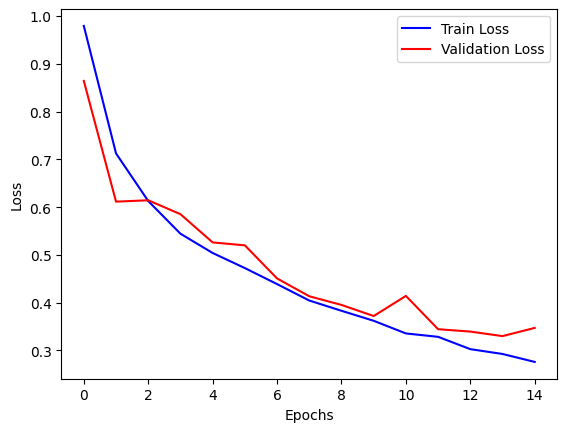

In [17]:
# Carica la history dal file JSON
with open('training_history.json', 'r') as f:
    history = json.load(f)


fig = plt.figure()
plt.plot(history['epoch_losses'], color='blue')
plt.plot(history['epoch_losses_val'], color='red')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')


**Check model predictions**

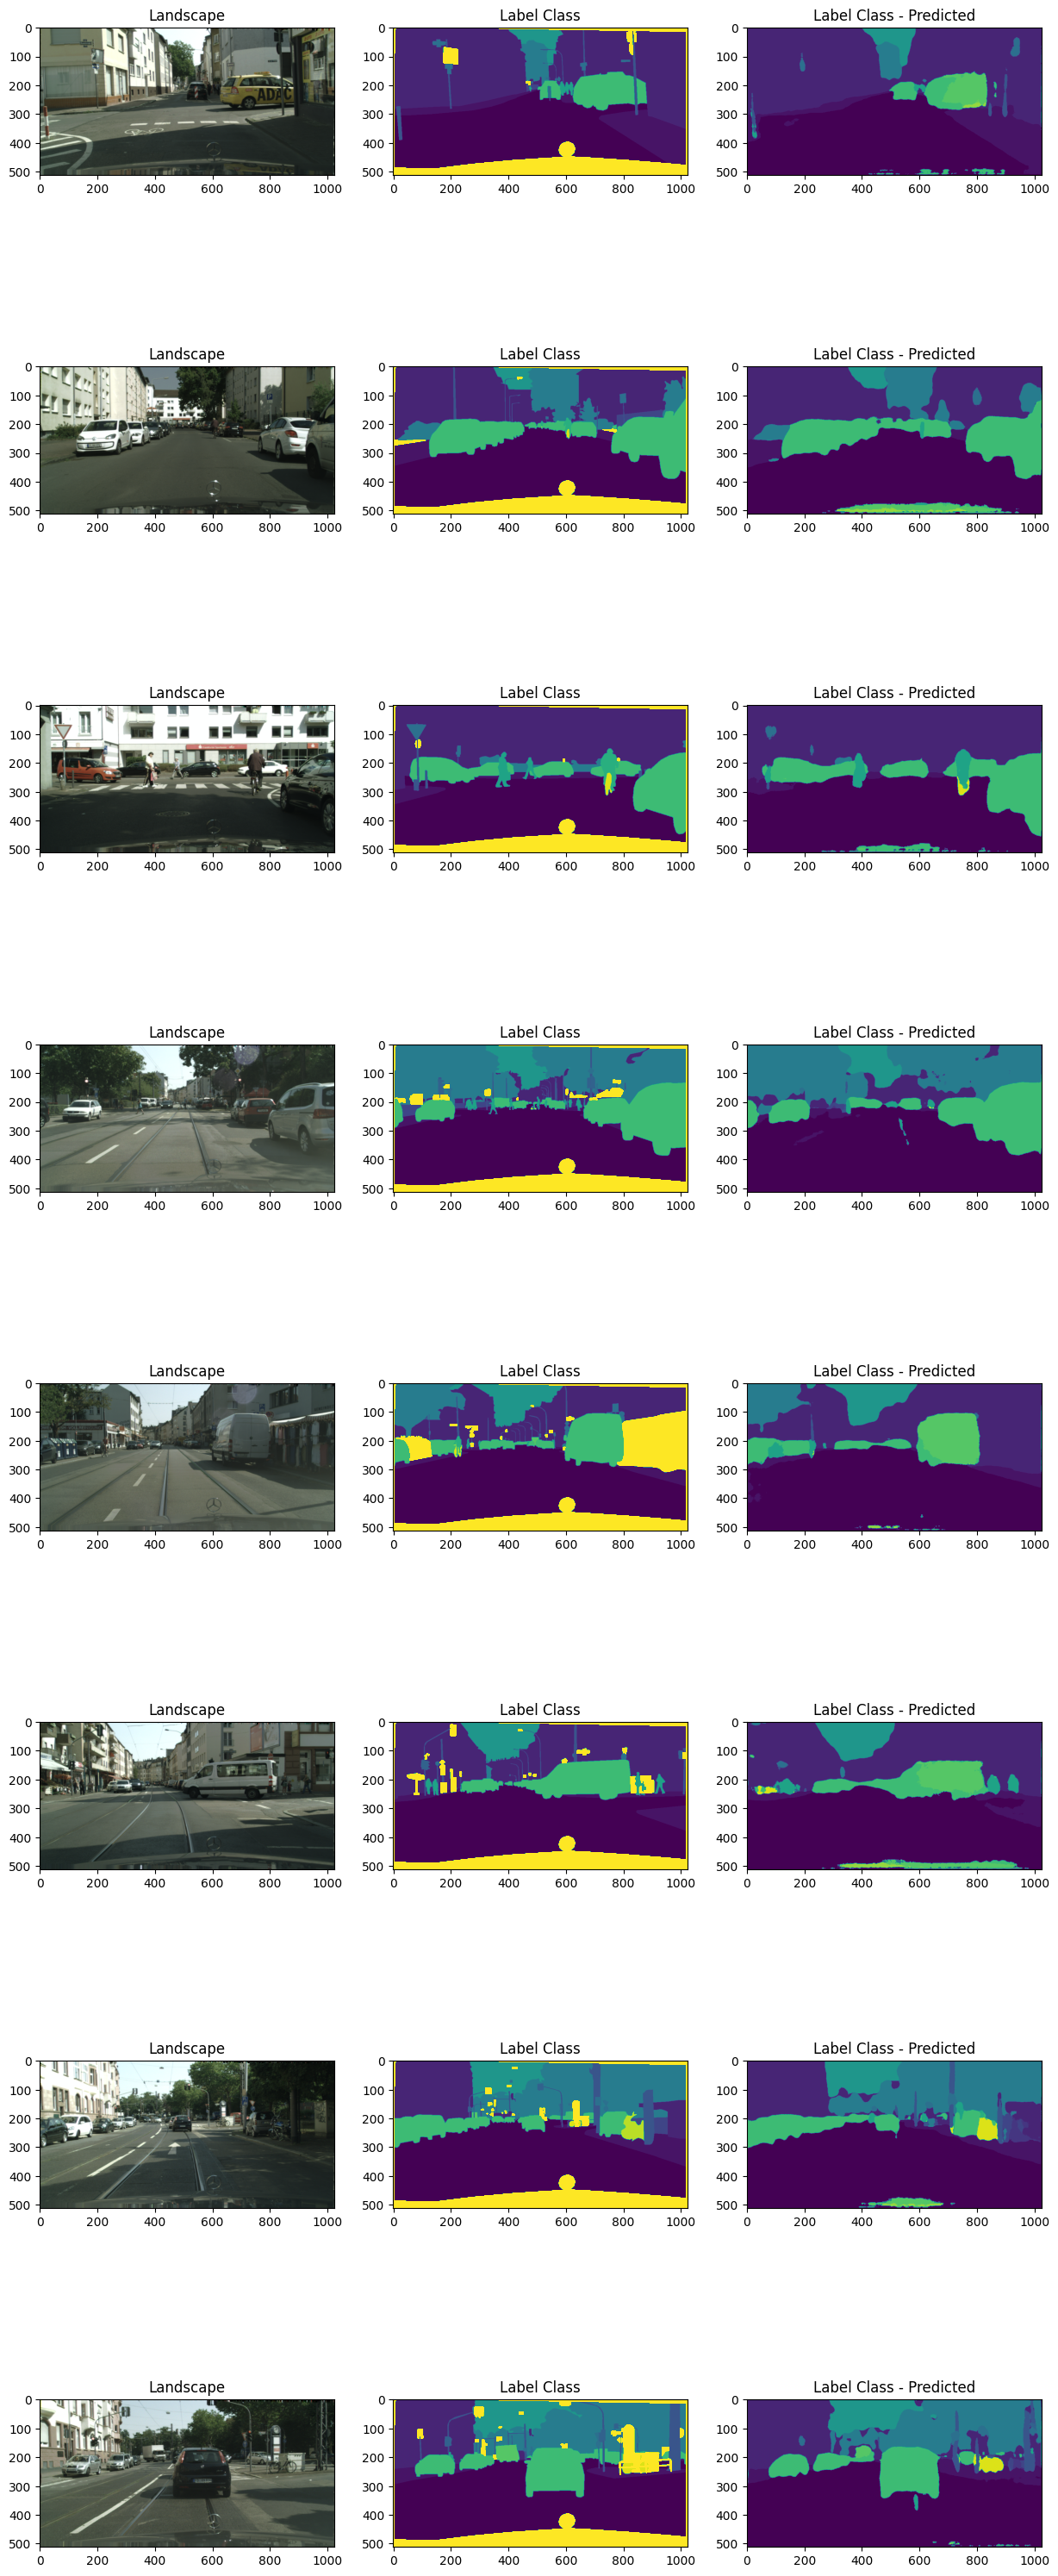

In [18]:
inverse_transform = T.Compose([
    T.Normalize(
        mean=(-0.28881703 / 0.18679116, -0.32694227 / 0.18973092, -0.28622528 / 0.18646142),
        std=(1 / 0.18679116, 1 / 0.18973092, 1 / 0.18646142)
    )
])

checkpoint = torch.load(checkpoint_path,  weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

X, Y = next(iter(test_dataloader))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
Y_pred = torch.argmax(Y_pred, dim=1)

test_batch_size = (len(X))

fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))
    
for i in range (test_batch_size):
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # Plot
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, clim=[0,19])
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted, clim=[0,19])
    axes[i, 2].set_title("Label Class - Predicted")

**Funzione di labeling** 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_cityscapes_prediction(image, prediction, ground_truth, num_classes, ignore_index=255):
    """
    Visualizza l'immagine originale accanto alla maschera colorata basata sulla predizione,
    ignorando i pixel della GT con valore specificato (es. 255).

    Args:
        image (numpy.ndarray or torch.Tensor): Immagine originale (HxWx3).
        prediction (numpy.ndarray or torch.Tensor): Label predetta (HxW).
        ground_truth (numpy.ndarray or torch.Tensor): Ground truth (HxW).
        num_classes (int): Numero totale di classi.
        ignore_index (int): Valore della GT da ignorare nella maschera.
    """
    # Se l'immagine è un tensore, convertila in numpy
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().detach().numpy()  # Cambia dimensioni da (C, H, W) a (H, W, C)

    # Se la predizione è un tensore, convertila in numpy
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.cpu().detach().numpy()

    # Se la GT è un tensore, convertila in numpy
    if isinstance(ground_truth, torch.Tensor):
        ground_truth = ground_truth.cpu().detach().numpy()

    # Assicuriamoci che l'immagine sia in formato uint8
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    # Genera colori casuali per ciascuna classe
    np.random.seed(42)  # Fissa il seed per colori consistenti
    class_colors = [tuple(np.random.randint(0, 256, 3)) for _ in range(num_classes)]

    # Creiamo una maschera colorata basata sulla predizione
    mask = np.zeros_like(image, dtype=np.uint8)
    for class_id, color in enumerate(class_colors):
        # Ignora i pixel dove la GT è uguale a ignore_index
        mask[(prediction == class_id) & (ground_truth != ignore_index)] = color

    # Sovrapponi la maschera sull'immagine originale
    overlay = (0.5 * image + 0.5 * mask).astype(np.uint8)

    # Trova le classi presenti nella predizione, escludendo pixel con GT = ignore_index
    unique_classes = np.unique(prediction[ground_truth != ignore_index])
    
    # Recupera i nomi delle classi presenti
    unique_names = [class_dict.get(class_id, 'Non trovato') for class_id in unique_classes]

    # Plot dell'immagine e della maschera
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(image)
    axes[0].set_title("Immagine Originale")
    axes[0].axis('off')

    axes[1].imshow(overlay)
    axes[1].set_title("Predizione Sovrapposta")
    axes[1].axis('off')

    # Crea una legenda con le classi presenti
    unique_colors = [class_colors[class_id] for class_id in unique_classes]
    handles = [plt.Rectangle((0, 0), 1, 1, color=np.array(color)/255) for color in unique_colors]
    plt.legend(handles, unique_names, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()


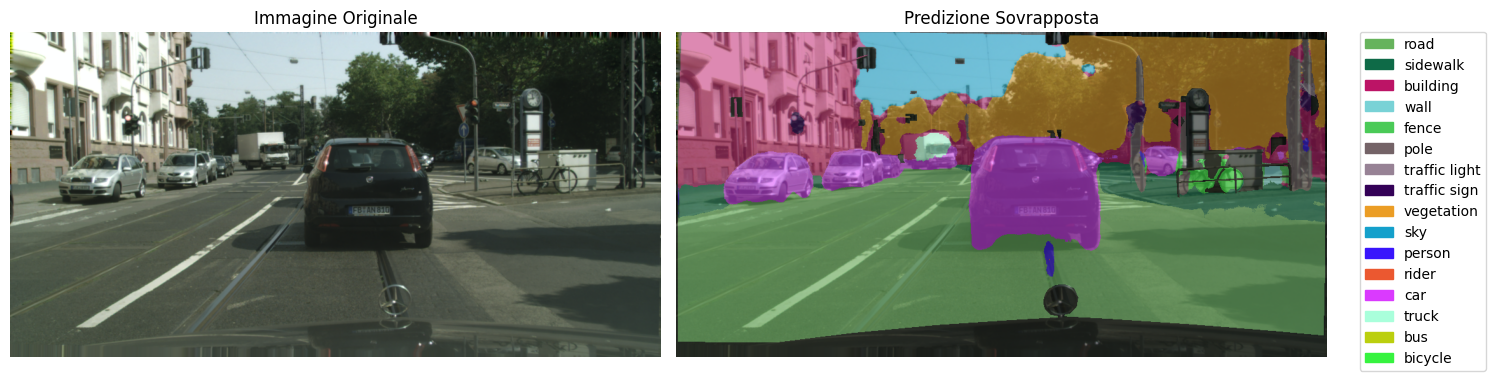

In [20]:
visualize_cityscapes_prediction(landscape, label_class_predicted, label_class, num_classes)

# Test

Mean IoU macro: 0.3486834073823596
Mean IoU micro: 0.7909257544411553
Mean IoU weighted: 0.8082851777001033


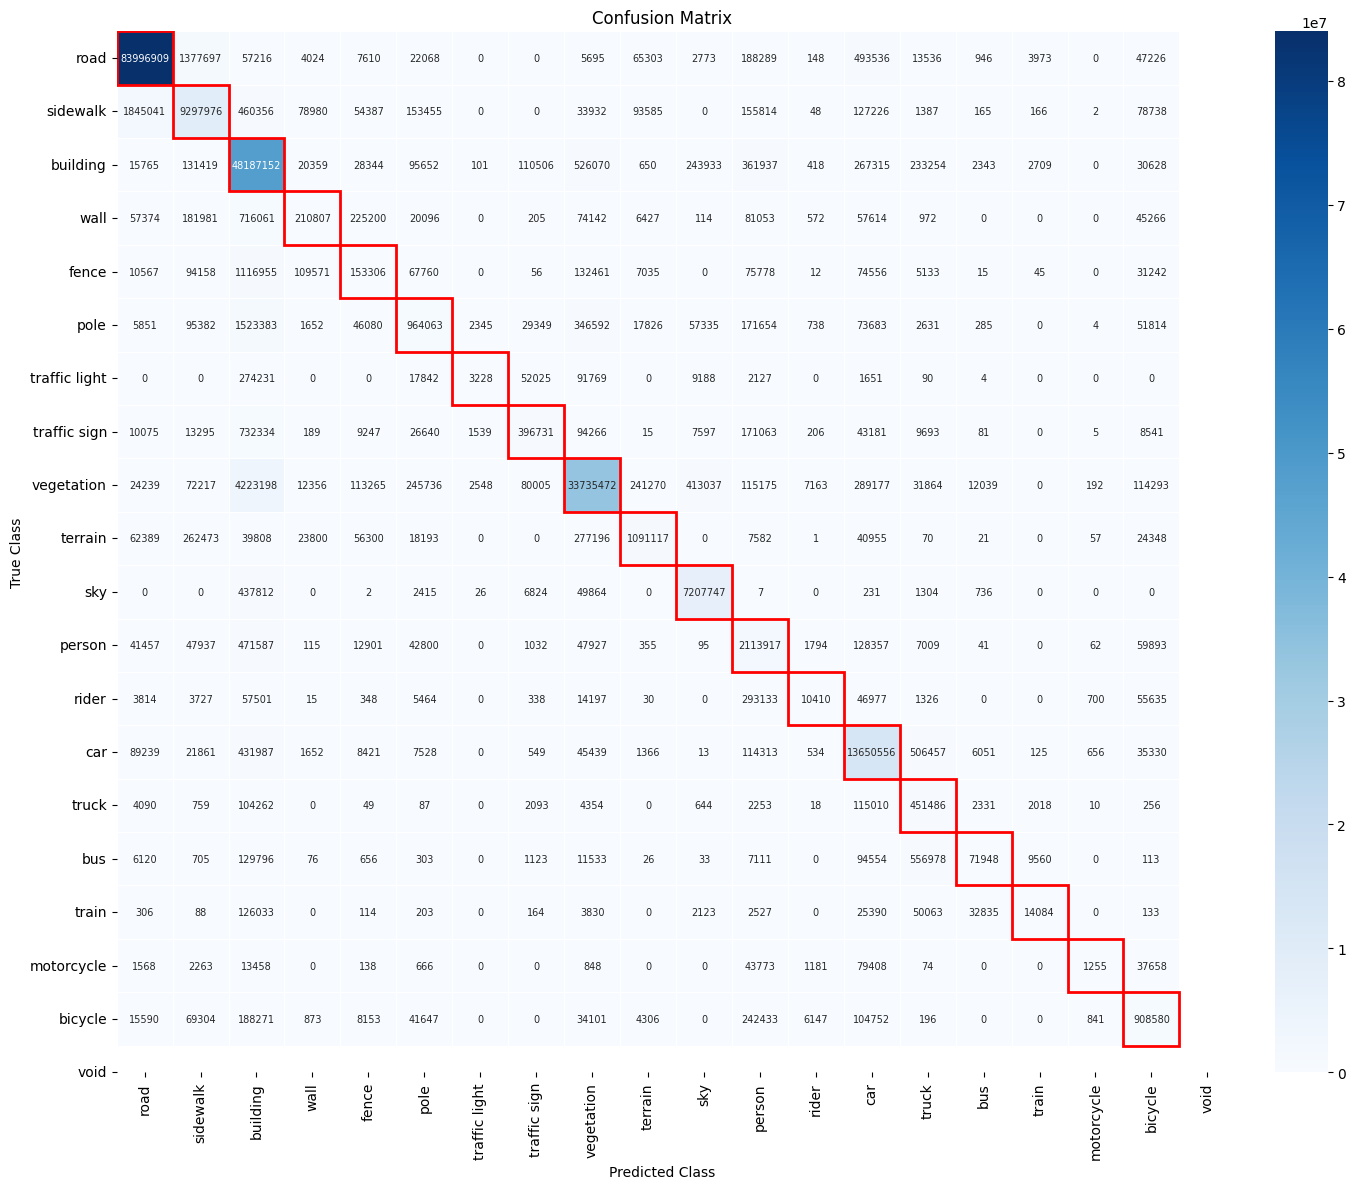

In [21]:
from torchmetrics import JaccardIndex
from sklearn.metrics import confusion_matrix
import seaborn as sns

iou_scores = []
iou_scores_micro = []
iou_scores_weighted = []

conf_matrix = np.zeros((num_classes, num_classes), dtype=int)  # Matrice di confusione inizializzata

jaccard = JaccardIndex(task='multiclass', num_classes=num_classes, ignore_index = 255)
jaccard_micro = JaccardIndex(task='multiclass', average='micro', num_classes=num_classes, ignore_index = 255)
jaccard_weighted = JaccardIndex(task='multiclass', average='weighted', num_classes=num_classes, ignore_index = 255)

for X,Y in test_dataloader:

    X,Y = X.to(device), Y.to(device)
    Y_pred = model(X)
    Y_pred = torch.argmax(Y_pred, dim=1)

    label_class = Y.cpu().detach().numpy()
    label_class_predicted = Y_pred.cpu().detach().numpy()
    

    iou_micro = jaccard_micro(Y_pred.cpu(), Y.cpu()).item()
    iou_weighted = jaccard_weighted(Y_pred.cpu(), Y.cpu()).item()
    iou = jaccard(Y_pred.cpu(), Y.cpu()).item()
    #print(iou)
    iou_scores.append(iou)
    iou_scores_micro.append(iou_micro)
    iou_scores_weighted.append(iou_weighted)

    # Aggiorna la matrice di confusione per l'immagine corrente
    conf_matrix += confusion_matrix(
        label_class.flatten(), 
        label_class_predicted.flatten(), 
        labels=np.arange(num_classes),  # Assicura che tutte le classi siano considerate
    )
    
# Plot della matrice di confusione
plt.figure(figsize=(15, 12))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    annot_kws={"size": 7},  # Dimensione del testo
    fmt="d", 
    xticklabels=[class_dict.get(cls, str(cls)) for cls in class_dict if cls!=-255],
    yticklabels=[class_dict.get(cls, str(cls)) for cls in class_dict if cls!=-255],
    cmap="Blues", 
    linewidths=0.5
)

ax = plt.gca()
for i in range(conf_matrix.shape[0]):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

# Media complessiva dell'IoU
print("Mean IoU macro:", np.mean(iou_scores))
print("Mean IoU micro:", np.mean(iou_scores_micro))
print("Mean IoU weighted:", np.mean(iou_scores_weighted))

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.tight_layout()  # Adatta automaticamente il layout
plt.show()

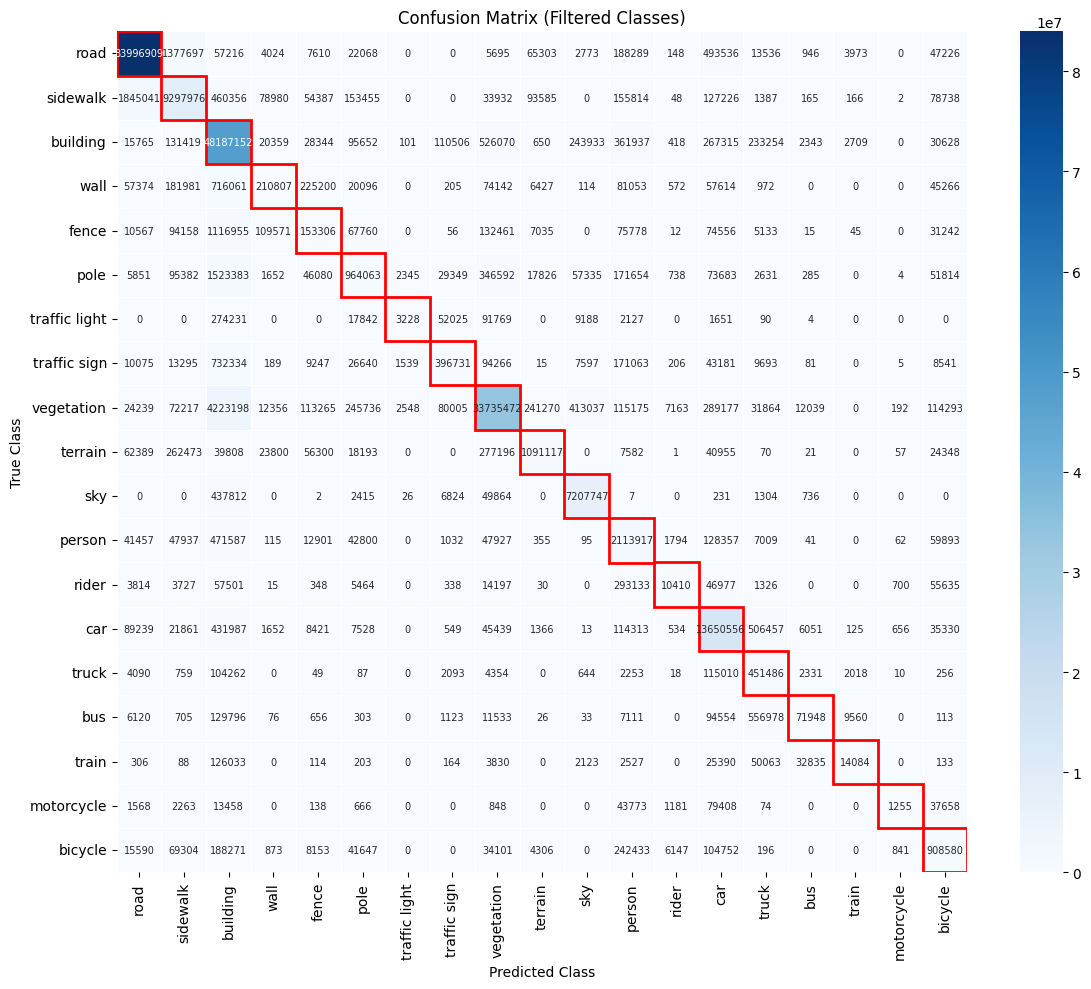

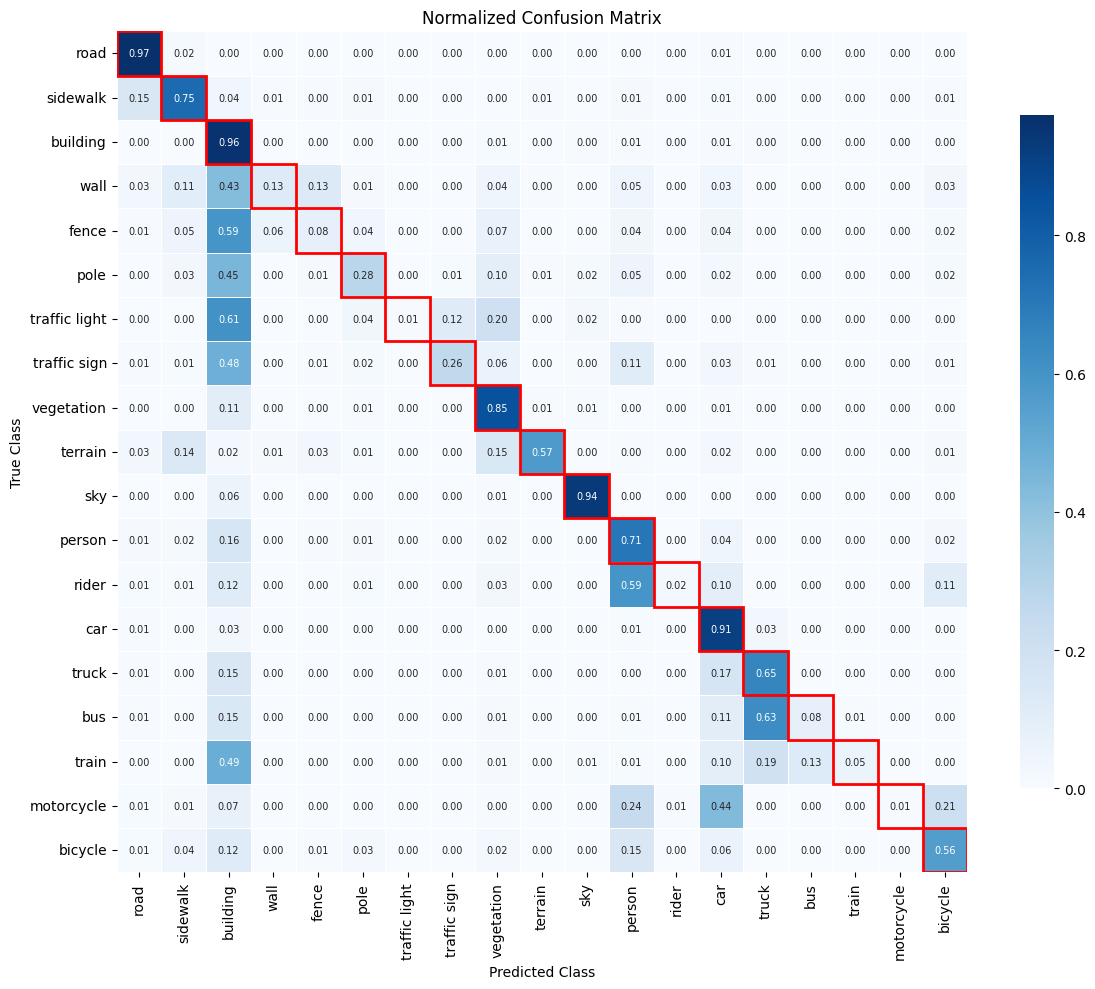

In [25]:
# Calcola la somma dei pixel per classe nella ground truth
class_frequencies = conf_matrix.sum(axis=1)

# Filtra solo le classi con almeno un certo numero di pixel
threshold = 100  # Cambia il valore a seconda delle tue esigenze
dominant_classes = [cls for cls, freq in enumerate(class_frequencies) if freq > threshold]

# Genera una matrice ridotta
conf_matrix_reduced = conf_matrix[np.ix_(dominant_classes, dominant_classes)]

# Visualizza la matrice ridotta
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_reduced, 
    annot=True, 
    annot_kws={"size": 7},  # Dimensione del testo
    fmt="d",
    xticklabels=[class_dict.get(cls, str(cls)) for cls in dominant_classes],
    yticklabels=[class_dict.get(cls, str(cls)) for cls in dominant_classes],
    cmap="Blues",
    linewidths=0.5
)

ax = plt.gca()
for i in range(conf_matrix.shape[0]):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix (Filtered Classes)")
plt.tight_layout()  # Adatta automaticamente il layout
plt.show()


# Normalizzazione per riga (valori percentuali), con gestione righe vuote
row_sums = conf_matrix_reduced.sum(axis=1, keepdims=True)
conf_matrix_normalized = np.divide(
    conf_matrix_reduced, 
    row_sums, 
    where=row_sums != 0  # Esegui la divisione solo se la somma della riga è diversa da zero
)

# Sostituisci eventuali NaN con 0 (righe con somma zero)
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)

# Trova i valori minimo e massimo della matrice normalizzata per regolare la colorbar
vmin = conf_matrix_normalized.min()
vmax = conf_matrix_normalized.max()

plt.figure(figsize=(12, 10))

# Crea la heatmap
sns.heatmap(
    conf_matrix_normalized, 
    annot=True, 
    annot_kws={"size": 7},  # Dimensione del testo
    fmt=".2f",
    xticklabels=[class_dict.get(cls, str(cls)) for cls in dominant_classes],
    yticklabels=[class_dict.get(cls, str(cls)) for cls in dominant_classes],
    cmap="Blues",  # Colormap
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},  # Aggiusta la dimensione della colorbar
    vmin=vmin,  # Imposta il minimo della colorbar
    vmax=vmax   # Imposta il massimo della colorbar
)

ax = plt.gca()
for i in range(conf_matrix.shape[0]):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()  # Adatta automaticamente il layout
plt.show()


In [26]:
from tabulate import tabulate

# Precision: true positives / (true positives + false positives)
precision = np.diag(conf_matrix) / np.maximum(conf_matrix.sum(axis=0), 1)

# Recall: true positives / (true positives + false negatives)
recall = np.diag(conf_matrix) / np.maximum(conf_matrix.sum(axis=1), 1)

# F1-score: harmonic mean of precision and recall (senza warning)
f1_score = np.zeros_like(precision)
valid_mask = (precision + recall) > 0
f1_score[valid_mask] = 2 * (precision[valid_mask] * recall[valid_mask]) / (precision[valid_mask] + recall[valid_mask])

# Metriche globali
micro_precision = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
micro_recall = micro_precision  # Uguale per il micro average
micro_f1 = micro_precision  # Uguale per il micro average

macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1_score)

# Costruzione della tabella delle classi
table_data = []
for cls in range(num_classes):
    class_name = class_dict.get(cls, f"Class {cls}")
    pred_count = conf_matrix.sum(axis=0)[cls]  # Previsioni per questa classe
    true_count = conf_matrix.sum(axis=1)[cls]  # Veri esempi per questa classe

    if true_count == 0 and pred_count == 0:
        # Classe completamente assente nel dataset di test
        table_data.append([class_name, "-", "-", "-", "Absent in test set"])
    elif true_count == 0:
        # Classe non presente nel dataset di test (nessun vero esempio)
        table_data.append([class_name, "-", "No true instances", "-", "No true instances"])
    elif pred_count == 0:
        # Classe mai predetta
        table_data.append([class_name, "No predictions", "-", "-", "Never predicted"])
    elif f1_score[cls] == 0:
        # Classe con tutte le predizioni sbagliate
        table_data.append([
            class_name,
            f"{precision[cls]:.2f}",
            f"{recall[cls]:.2f}",
            f"{f1_score[cls]:.2f}",
            "All predictions incorrect"
        ])
    else:
        # Classe valida con metriche calcolabili
        table_data.append([
            class_name,
            f"{precision[cls]:.2f}",
            f"{recall[cls]:.2f}",
            f"{f1_score[cls]:.2f}",
            "OK"
        ])

# Tabella delle metriche globali
global_metrics = [
    ["Micro Precision", f"{micro_precision:.2f}"],
    ["Micro Recall", f"{micro_recall:.2f}"],
    ["Micro F1-score", f"{micro_f1:.2f}"],
    ["Macro Precision", f"{macro_precision:.2f}"],
    ["Macro Recall", f"{macro_recall:.2f}"],
    ["Macro F1-score", f"{macro_f1:.2f}"]
]

# Stampa delle tabelle
print("Class-wise metrics:")
print(tabulate(
    table_data,
    headers=["Class", "Precision", "Recall", "F1-score", "Status"],
    tablefmt="grid"
))

print("\nGlobal metrics:")
print(tabulate(global_metrics, headers=["Metric", "Value"], tablefmt="grid"))


Class-wise metrics:
+---------------+-------------+----------+------------+----------+
| Class         |   Precision |   Recall |   F1-score | Status   |
+===============+=============+==========+============+==========+
| road          |        0.97 |     0.97 |       0.97 | OK       |
+---------------+-------------+----------+------------+----------+
| sidewalk      |        0.8  |     0.75 |       0.77 | OK       |
+---------------+-------------+----------+------------+----------+
| building      |        0.81 |     0.96 |       0.88 | OK       |
+---------------+-------------+----------+------------+----------+
| wall          |        0.45 |     0.13 |       0.2  | OK       |
+---------------+-------------+----------+------------+----------+
| fence         |        0.21 |     0.08 |       0.12 | OK       |
+---------------+-------------+----------+------------+----------+
| pole          |        0.56 |     0.28 |       0.38 | OK       |
+---------------+-------------+----------+

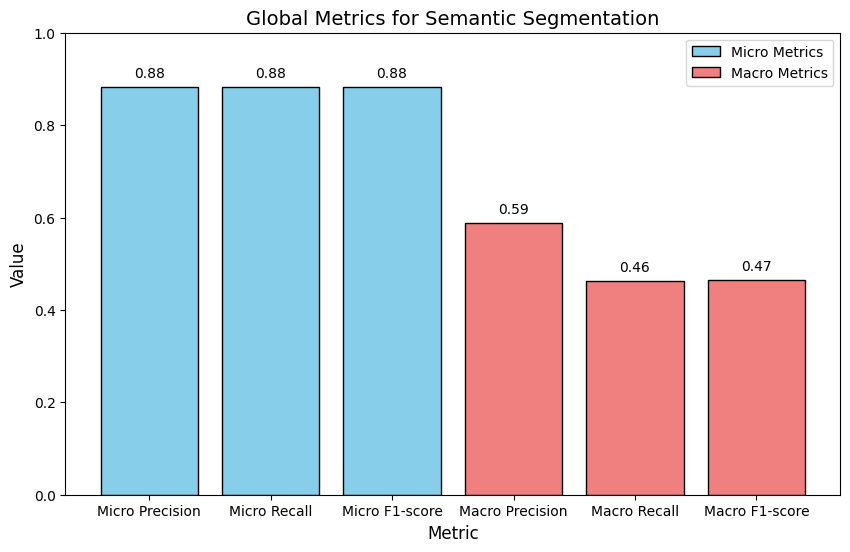

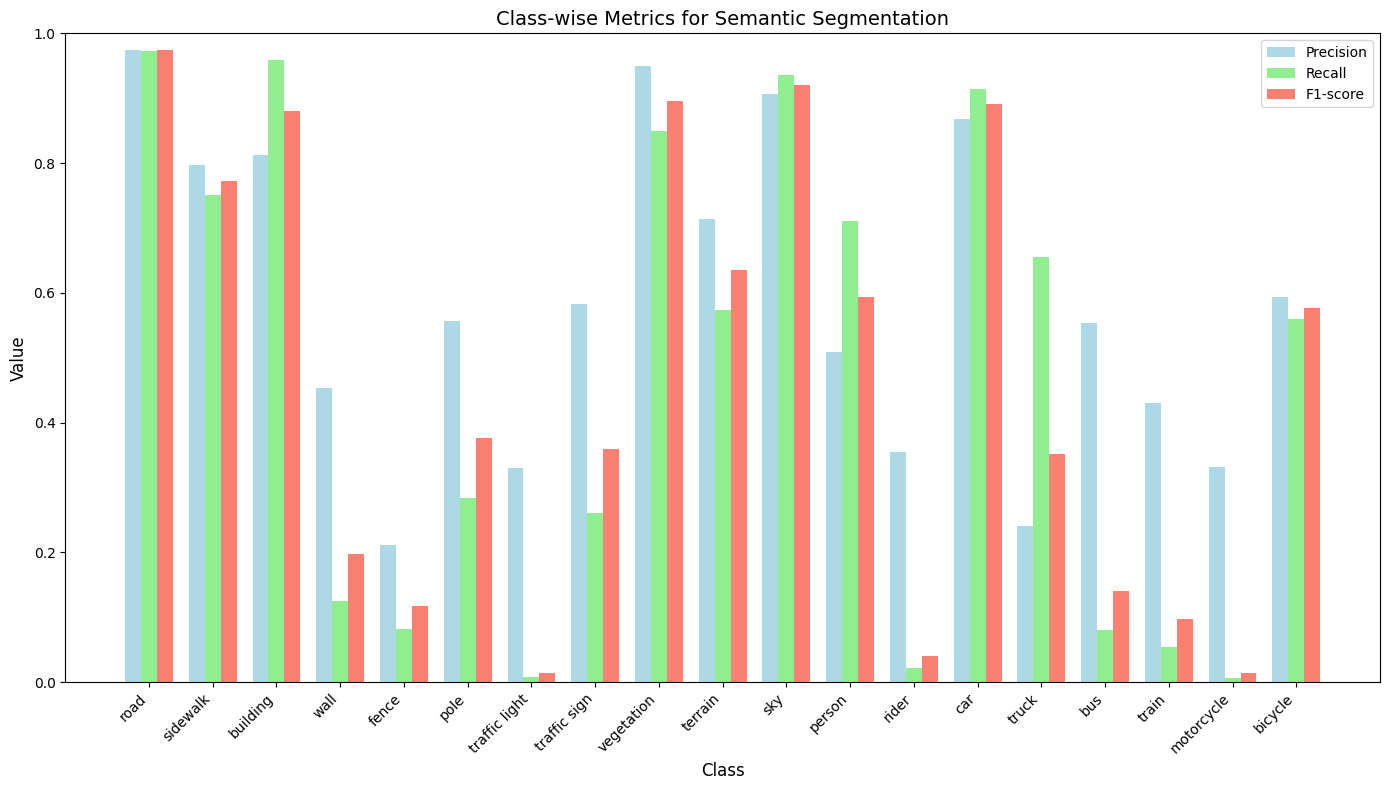

In [27]:
import matplotlib.pyplot as plt

# Dati per il grafico
global_metric_names = ["Micro Precision", "Micro Recall", "Micro F1-score", 
                       "Macro Precision", "Macro Recall", "Macro F1-score"]
global_metric_values = [micro_precision, micro_recall, micro_f1, 
                        macro_precision, macro_recall, macro_f1]

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))

# Barre per le metriche Micro
plt.bar(global_metric_names[:3], global_metric_values[:3], color='skyblue', edgecolor='black', label="Micro Metrics")

# Barre per le metriche Macro
plt.bar(global_metric_names[3:], global_metric_values[3:], color='lightcoral', edgecolor='black', label="Macro Metrics")

# Aggiungi etichette e titolo
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.ylim(0, 1)  # Le metriche sono tra 0 e 1
plt.title("Global Metrics for Semantic Segmentation", fontsize=14)

# Aggiungi valori sopra le barre
for i, v in enumerate(global_metric_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

# Aggiungi la legenda
plt.legend()

# Mostra il grafico
plt.show()

# Preparazione dei dati per il grafico
class_names = [class_dict.get(cls, f"Class {cls}") for cls in range(num_classes)]
precision_values = precision
recall_values = recall
f1_values = f1_score

x = range(len(class_names))  # Indici delle classi

# Creazione del grafico a barre raggruppate
plt.figure(figsize=(14, 8))
width = 0.25  # Larghezza delle barre

plt.bar([p - width for p in x], precision_values, width=width, label='Precision', color='lightblue')
plt.bar(x, recall_values, width=width, label='Recall', color='lightgreen')
plt.bar([p + width for p in x], f1_values, width=width, label='F1-score', color='salmon')

# Etichette asse x
plt.xticks(x, class_names, rotation=45, ha='right', fontsize=10)

# Aggiungi etichette e titolo
plt.xlabel("Class", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.ylim(0, 1)  # Le metriche sono tra 0 e 1
plt.title("Class-wise Metrics for Semantic Segmentation", fontsize=14)
plt.legend()

# Mostra il grafico
plt.tight_layout()
plt.show()